In [1]:
from keras.models import load_model
import cv2
import visvis as vv
import numpy as np
from skimage import measure
from matplotlib import pyplot as plt
from matplotlib.collections import PolyCollection
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import mcubes
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10,10]

import custom_layers

Using TensorFlow backend.


# Example usage of vrn-unguided-keras.h5
## Modified by Qhan
* Rendering Texture
    * maplotlib.pyplot
    * visvis.mesh
    
* Download the h5py file here:
https://drive.google.com/file/d/1oh8Zpe4wh00iXcm8ztRsi5ZL6GMkHdjj/view?usp=sharing

In [2]:
custom_objects = {
    'Conv': custom_layers.Conv,
    'BatchNorm': custom_layers.BatchNorm,
    'UpSamplingBilinear': custom_layers.UpSamplingBilinear
}
model = load_model('vrn-unguided-keras.h5', custom_objects=custom_objects)

In [67]:
img = cv2.imread('qhan.png')
img = cv2.resize(img, (192, 192))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = np.swapaxes(img, 2, 0)
img = np.swapaxes(img, 2, 1)
img = np.array([img])

In [74]:
pred = model.predict(img)
print(pred[0].shape)
vol = pred[0] * 255

(200, 192, 192)


## Interpolation of Colors

In [75]:
def interp(x, v):
    d0, d1 = x, 1-x
    v0, v1 = v
    return (v0 * d1 + v1 * d0)

def interp2d(xy, v):
    x, y = xy
    u = interp(x, v[0])
    d = interp(x, v[1])
    return interp(y, [u, d])

def interpColors(verts, image):
    colors = []
    #im = cv2.GaussianBlur(image, (3, 3), 0)
    for v in verts:
        x, y = v[:2]
        c, r = int(x), int(y)
        corners = im[r:r+2, c:c+2].astype(float) / 256
        result = interp2d([x-c, y-r], corners)
        colors += [result]
    return colors

## pyplot trisurf

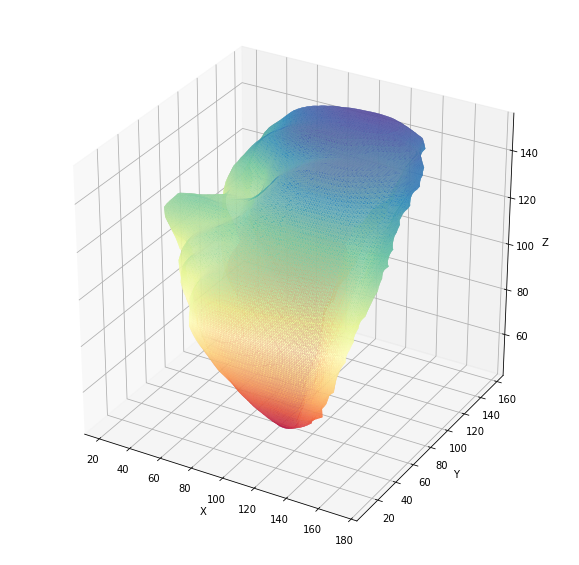

In [76]:
plt.clf()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
verts, faces = mcubes.marching_cubes(vol, 20) # verts: x, y, z

ax.plot_trisurf(192-verts[:, 0], 192-verts[:, 1], faces, verts[:, 2], cmap='Spectral', lw=2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

## pyplot polygons

vertices: 89918 
faces: 179832
179831

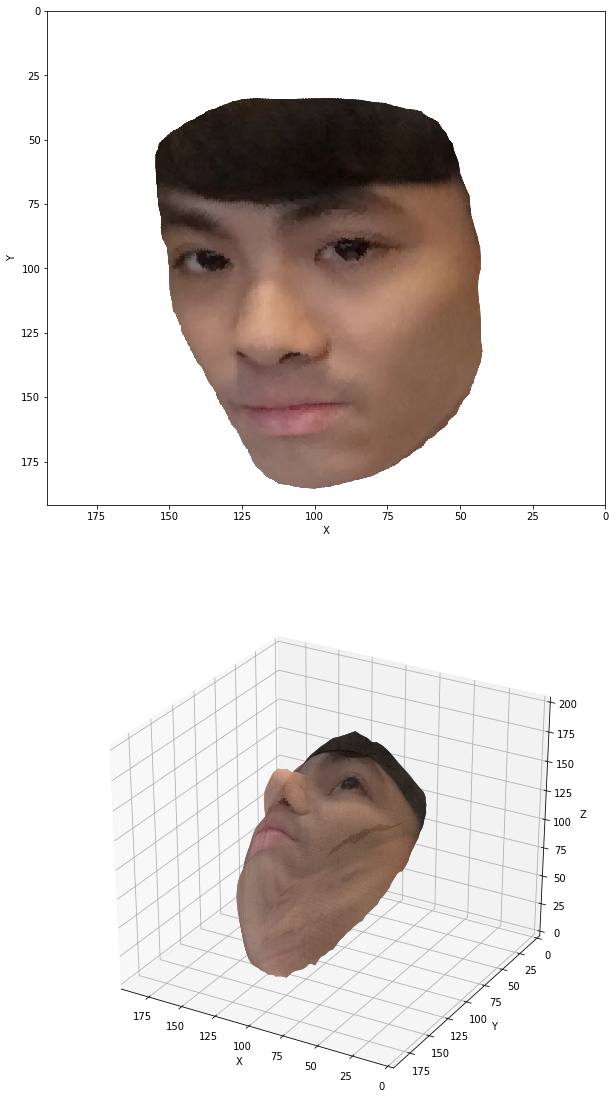

In [7]:
verts, faces, normals, values = measure.marching_cubes_lewiner(vol, level=10, step_size=1)
print('vertices:', len(verts), '\nfaces:', len(faces))

# verts: (z, y, x) -> convert to (x, y, z)
x = np.array(verts[:, 2])
verts[:, 2] = np.array(verts[:, 0])
verts[:, 0] = np.array(x)

colors = interpColors(verts, im)


plt.clf()
fig = plt.figure(figsize=(10, 20))

ax = fig.add_subplot(211)
ax.scatter(verts[:, 0], verts[:, 1], color=colors, s=20)
ax.set_xlim(192, 0)
ax.set_ylim(192, 0)
ax.set_xlabel('X')
ax.set_ylabel('Y')


ax = fig.add_subplot(212, projection='3d')

for i, face in enumerate(faces):
    print('\r%d' % i, end='')
    triangle = verts[face]
    mesh = Poly3DCollection([triangle], facecolor=colors[face[0]]) # select one vertice as face color
    ax.add_collection3d(mesh)

ax.set_xlim(192, 0)
ax.set_ylim(192, 0)
ax.set_zlim(0, 200)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

## visvis

In [7]:
vv.settings.figureSize = (720, 720)

**vv.mesh**

In [78]:
verts, faces, normals, values = measure.marching_cubes_lewiner(vol, level=10, step_size=1)

# verts: (z, y, x) -> convert to (x, y, z)
x = np.array(verts[:, 2])
verts[:, 2] = np.array(verts[:, 0])
verts[:, 0] = np.array(x)


vv.clf()

t = vv.imshow(im, interpolate=True)

colors = interpColors(verts, im)
m = vv.mesh(verts, faces, normals, colors)
m.faceShading = 'gouraud'
m.edgeShading = None

l = vv.gca()
l.light0.ambient = 0.9 # 0.2 is default for light 0
l.light0.diffuse = 1.0 # 1.0 is default

a = vv.gca()
a.camera.fov = 0 # orthographic

vv.use().Run()

**vv.volshow()**  *(old method)*

In [9]:
im = img[0]
im = np.swapaxes(im, 0, 1)
im = np.swapaxes(im, 1, 2)
volRGB = np.stack(((vol > 1) * im[:,:,0],
                   (vol > 1) * im[:,:,1],
                   (vol > 1) * im[:,:,2]), axis=3)

vv.clf()

t = vv.imshow(im, interpolate=True)
v = vv.volshow3(volRGB, renderStyle='iso')

l = vv.gca()
l.light0.ambient = 0.9 # 0.2 is default for light 0
l.light0.diffuse = 1.0 # 1.0 is default

a = vv.gca()
a.camera.fov = 0 # orthographic

vv.use().Run()

## show z depth layers

In [ ]:
plt.clf()

for i, p in enumerate(volRGB[80:180:5]):
    plt.subplot(5, 4, i + 1)
    plt.imshow(p)
    
plt.show()